<img src="https://www.strath.ac.uk/media/1newwebsite/webteam/logos/xUoS_Logo_Horizontal.png.pagespeed.ic.M6gv_BmDx1.png" width="350" align="left" style="left">

# 2. Amplitude Modulation and Demodulation <a class="anchor" id="A_mod_demod"></a>

Amplitude Modulation is the process of modifying one signal by another through the altering of signal amplitude. This makes for a good introduction to the world of modulation as the process and circuit design are straightforward. The weakness of AM however is that upon reconstruction the signal will have halved in amplitude.

## Table of Contents

* [2. Amplitude Modulation and Demodulation](02_amplitude_modulation.ipynb)
    * [2.1 Amplitude Modulation of a Baseband Signal](#A_mod)
    * [2.2 Demodulation of the Baseband Signal](#A_demod)
    * [2.3 Demodulation Phase Error](#A_phase_error)
    * [2.4 Conclusion](#conclusion)

**Import Libraries**

For this notebook we will be using NumPy for computation and MatplotLib for Matlab-like visualisation of our waveforms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 2.1 Amplitude Modulation of a Baseband Signal <a class="anchor" id="A_mod"></a>

We will begin with a simple modulation scheme, mixing a low frequency baseband signal, $g(t)$, with a high frequency carrier, $c(t)$, to produce a modulated signal, $s(t)$. This signal can then be transmitted from an RF antenna. The designof the RF transmitter can be seen in [Figure 1](#fig-1).

<a class="anchor" id="fig-1"></a>
<figure>
<img src='./images/AM_mod.png' height='30%' width='30%'/>
    <figcaption><b>Figure 1: Amplitude Modulation of a Baseband Signal</b></figcaption>
</figure>

First we establish the basic paremeters for our design. For demonstration purposes the sampling rate is set to 1 MHz, whilst the input signal is of 20 KHz, however, these numbers can be easily scaled into the GHz for an RFSoC transmitter.

In [2]:
# Set basic params
fs = 1400000 # sample rate
fb = 20000 # frequency of baseband signal
A = 200 # baseband signal amplitude
N_fft = 512 # fft size

t = np.arange(N_fft)/fs #time scale

Next, we define an input signal, $g(t)$:

$g(t) = A\cos(2 \pi f_{b} t)$

where A is the amplitude and $f_{b}$ is the frequency of the baseband signal.

For demonstration purposes a single tone signal will be used, however a more general baseband signal with frequency components from 0 to $f_{b}$ can be modulated with the same approach.

In [3]:
# Define input signal
g = A*np.cos(2*np.pi*fb*t) 

The FFT of the signal is now found, for frequency domain plotting. 

In [4]:
# Calculate FFT
g_fft_result = np.fft.fft(g, N_fft)

# Get the corresponding frequencies, that depend on N_fft and Fs - freq. domain x axis
freqs = np.fft.fftfreq(N_fft,1/fs)

This baseband information signal can be plotted in both time and frequency domains. 

We can observe a cosine with amplitude A in the time domain and a single tone at $f_{b}$ in the frequency domain.

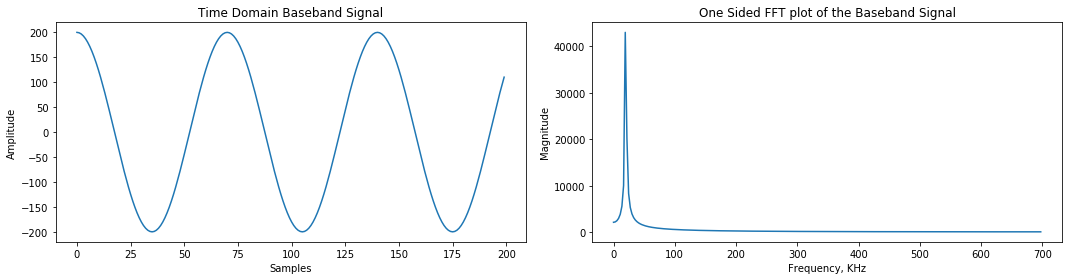

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(g[:200])
axs[0].set_title('Time Domain Baseband Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(g_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Baseband Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, KHz')
fig.tight_layout()

Similarly, a high frequency carrier signal can be defined. 

$c(t) = \cos(2 \pi f_{c} t)$

In [6]:
fc = 300000 # Carrier Frequency 

# Define Carrier Signal
c = np.cos(2*np.pi*fc*t) 

In [7]:
# Find FFT of Carrier
c_fft_result = np.fft.fft(c, N_fft)

We can now plot this carrier signal in time and frequency domains. This signal can be seen to be of a much higher frequency than the baseband signal, comprising of a single tone at $f_{c}$ in the frequency domain.

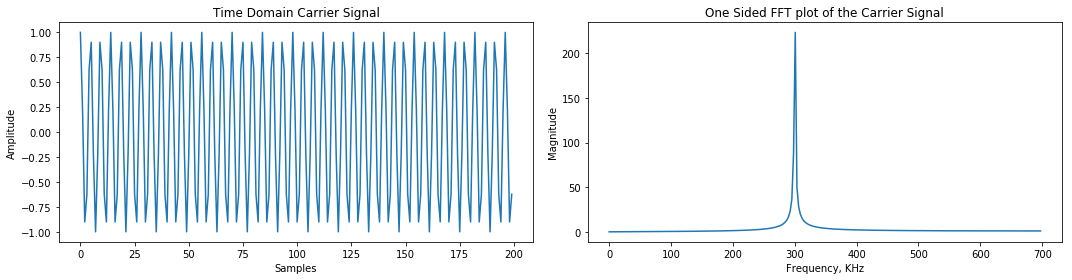

In [8]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(c[:200])
axs[0].set_title('Time Domain Carrier Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(c_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Carrier Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, KHz')
fig.tight_layout()

A modulated signal, $s(t)$, can now be obtained by multiplying our information signal, $g(t)$, by the carrier signal $c(t)$.

$s(t) = c(t) \times g(t)$

$s(t) = \cos(2 \pi f_{c} t) \times A\cos(2 \pi f_{b} t)$

Using trigonometry we can see that:

$s(t) = \frac{A}{2} \cos(2 \pi (f_{c} - f_{b}) t) + \frac{A}{2} \cos(2 \pi (f_{c} + f_{b}) t)$

In Python, this modulated signal can be easily obtained by mutliplying the carrier signal $c(t)$ by the information signal, $g(t)$:

In [9]:
# Find Modulated Signal
s = g*c # Information signal, g(t), multiplied by carrier signal, c(t).

In [10]:
# Find FFT of Modulated Signal
s_fft_result = np.fft.fft(s, N_fft)

We can plot the results of this modulation in time and frequency domain. 

In the frequency domain we can see frequency responses at $f_{c} - f_{b}$ and $f_{c} + f_{b}$. Therefore we must transmit data using a bandwidth of $2 f_{b}$

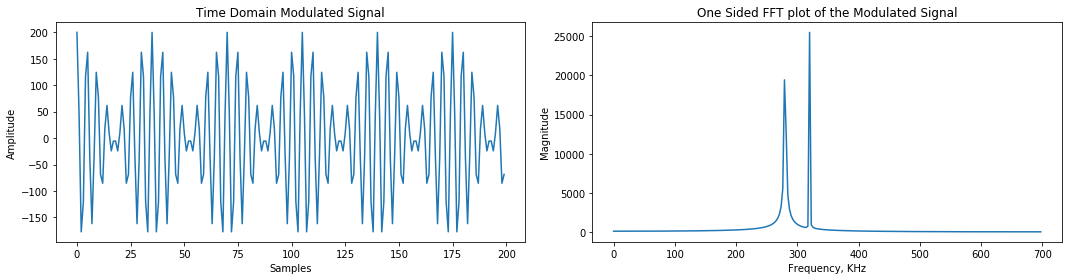

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(s[:200])
axs[0].set_title('Time Domain Modulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(s_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Modulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, KHz')
fig.tight_layout()

### 2.2 Demodulation of the Baseband Signal <a class="anchor" id="A_demod"></a>

At the receiver, this modulated signal can be 'perfectly' demodulated using a local carrier which matches the transmission carrier. The RF receiver design can be seen in [Figure 2](#fig-2).

<a class="anchor" id="fig-2"></a>
<figure>
<img src='./images/AM_Demod.png' height='30%' width='30%'/>
    <figcaption><b>Figure 2: Amplitude Demodulation of a Baseband Signal</b></figcaption>
</figure>

Demodulation can be seen as the reverse process of modulation. The modulated signal, $s(t)$, is multiplied by the carrier signal, $c(t)$, to produce a demodulated signal, $x(t)$.

$x(t) = c(t) \times s(t)$

This correctly reconstructs the input signal, however unwanted high frequency components remain.

$x(t) = \frac{A}{2} \cos(2 \pi f_{b} t) + \frac{A}{4} \cos(2 \pi (2f_{c} - f_{b}) t) + \frac{A}{4} \cos(2 \pi (2f_{c} + f_{b}) t)$

Within Python, this demodulation can be performed by multiplying the carrier signal, $c(t)$, by the received signal, $s(t)$.

In [12]:
# Find Demodulated Signal
x = c*s # multiplication of carrier and received signals to perform demodulation

In [13]:
# Find FFT of Demodulated Signal
x_fft_result = np.fft.fft(x, N_fft)

This demodulated signal can now be plotted in time and frequency domains. 

We can see that the original information signal at $f_{b}$ has been successfully recovered, however unwanted high frequency components sitting at $2f_{c} - f_{b}$ and $2f_{c} + f_{b}$ are present.

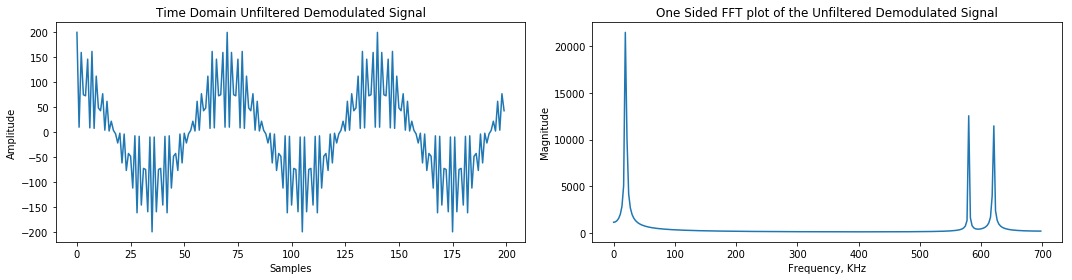

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(x[:200])
axs[0].set_title('Time Domain Unfiltered Demodulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(x_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Unfiltered Demodulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, KHz')
fig.tight_layout()

As we can see from the above figure, the demodulated signal has been successfully extracted, however unwanted high frequency components remain in the signal. These components can be removed using a lowpass filter, which we will design using the window method. This approach simply windows an ideal impulse response $h_d(n)$ by multiplying it by a window function $w(n)$:

$h(n) = w(n).h_d(n)$

For more information on filter design, please see the [Digital Filter Design notebook](./strath-sdr/rfsoc-studio/notebooks/pystrath-sdr/digital_filters/01_digital_filter_design.ipynb).

In [15]:
f_cutoff = 0.1 # Cutoff frequency as a fraction of the sampling rate
b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).

N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # N is odd.
n = np.arange(N)

h = np.sinc(2 * f_cutoff * (n - (N - 1) / 2)) # Compute sinc filter.
w = np.blackman(N) # Compute Blackman window.
h = h * w # Multiply sinc filter by window.
h = h / np.sum(h) # Normalize to get unity gain.

The lowpass filter can be applied to the demodulated signal using convolution. Within Python this can be performed simply by using np.convolve().

In [16]:
u = np.convolve(x, h)

The results of this low pass filter can be plotted, alongside the unfiltered signal. 

The 'cost' of amplitude scaling demodulation, as the name suggests, is a 50% amplitude scaling. This is particularly clear in the time domain plot. In the frequency domain we can clearly see that the high frequency components are removed, leaving only the desired baseband signal.

With the removal of the high frequency components, the desired output can be obtained as:

$u(t) = \frac{A}{2} \cos(2 \pi f_{b} t)$

In [17]:
u_fft_result = np.fft.fft(u, N_fft)

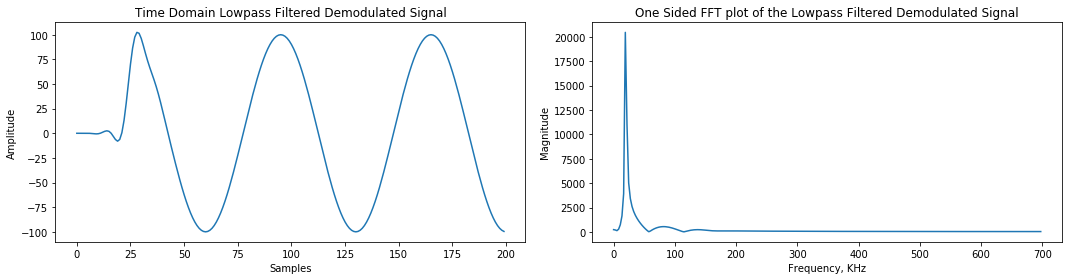

In [18]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(u[:200])
axs[0].set_title('Time Domain Lowpass Filtered Demodulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(u_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Lowpass Filtered Demodulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, KHz')
fig.tight_layout()

## 2.3 Demodulation Phase Error <a class="anchor" id="A_phase_error"></a>

If the local oscillator is not exactly in phase with the received signal, the resulting phase error will cause an attenuation by a factor of $\cos(\theta)$.

In [19]:
# Find phaseshifted local carrier
phaseshift = (np.pi/3) #60 degree phase shift
phase_carrier = np.cos(2*np.pi*fc*t + phaseshift) # Apply phaseshift to local receiver Carrier

# Find demodulated signal using new carrier - Modulated signal remains identical to before
phase_demodulation = phase_carrier*s # Demodulate Signal

# Apply Lowpass filter to demodulated signal
lp_phaseshift = np.convolve(phase_demodulation, h)

This concept can be shown by plotting the low pass filtered demodulated signal again, but incorporating a phase error into the local carrier signal.

By using a phase error of $\frac{\pi}{3}$ we observe an attenuation of $\cos(\frac{\pi}{3}) = 0.5.$

Therefore, in the time domain we can observe an amplitude of $\frac{A}{4}$ compared to the transmitted signal. 

In [20]:
# Find PhaseShifted FFT Signal
phaseshift_fft_result = np.fft.fft(lp_phaseshift, N_fft)

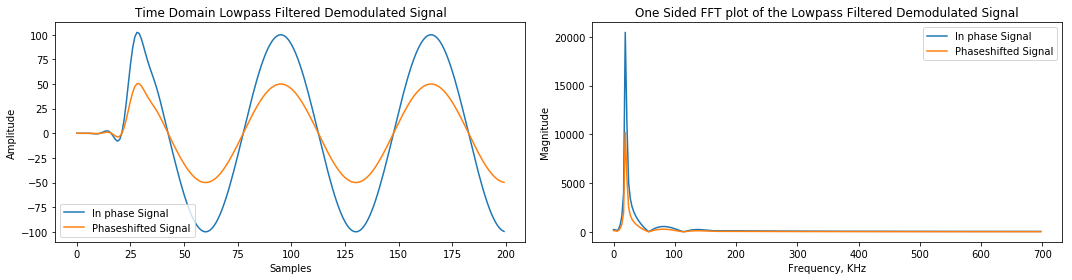

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(u[:200])
axs[0].plot(lp_phaseshift[:200])
axs[0].set_title('Time Domain Lowpass Filtered Demodulated Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')
axs[0].legend(('In phase Signal', 'Phaseshifted Signal'))

axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(u_fft_result[:int(N_fft/2)]))
axs[1].plot(freqs[:int(N_fft/2)]/1000, np.abs(phaseshift_fft_result[:int(N_fft/2)]))
axs[1].set_title('One Sided FFT plot of the Lowpass Filtered Demodulated Signal')
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('Frequency, KHz')
axs[1].legend(('In phase Signal', 'Phaseshifted Signal'))
fig.tight_layout()

## 2.4 Conclusion <a class="anchor" id="conclusion"></a>

So far we have shown how amplitude modulation may be used to transmit a baseband signal at much higher frequencies whilst being able to recreate the original signal at the receiver. However there is an issue of spectral inefficiency - the baseband is $f_{b}$ Hz wide but the modulated signal is $2f_{b}$. Therefore we require double the bandwidth to transmit the signal.

This problem can be addressed using QAM modulation schemes, addressed in the next notebook.

[⬅️ Previous Notebook](01_introduction.ipynb) | | [Next Notebook ➡️](03_QAM_modulation.ipynb)

----
----